In [1]:
import tqdm
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union
from tabulate import tabulate
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# from sklearnex import patch_sklearn, config_context


In [2]:
DIABETIC_DATA = "../data/diabetic_data.csv"
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
df = pd.read_csv(DIABETIC_DATA)
# df.head(5)

In [3]:
df.duplicated(subset = ['patient_nbr']).sum()
df['patient_nbr'].value_counts()

# Check the number of patients with unique entries
df['patient_nbr'].value_counts()[df['patient_nbr'].value_counts() == 1].shape[0]

# Check the number of patients with multiple entries
df['patient_nbr'].value_counts()[df['patient_nbr'].value_counts() != 1].shape[0]

16773

In [4]:
# Keep the latest record
df.drop_duplicates(subset = ['patient_nbr'], keep = 'last', inplace = True)

# now we will remove the patient-number column
df.drop(['patient_nbr'], axis=1, inplace=True)

In [5]:
df.replace("?", np.nan, inplace=True)

In [6]:
def replace_values_with_nan(df, replacements):
    for column, values in replacements.items():
        for value in values:
            df[column] = df[column].replace(value, np.nan)

    df[list(replacements.keys())] = df[list(replacements.keys())].astype('object')
    
    return df

replacements = {
    'admission_type_id': [5, 6, 8],
    'discharge_disposition_id': [18, 25, 26],
    'admission_source_id': [9, 15, 17, 20, 21]
}

df = replace_values_with_nan(df, replacements)

In [7]:
df.isnull().sum()

encounter_id                    0
race                         1878
gender                          0
age                             0
weight                      68671
admission_type_id            7444
discharge_disposition_id     2964
admission_source_id          5133
time_in_hospital                0
payer_code                  30085
medical_specialty           34525
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         17
diag_2                        290
diag_3                       1146
number_diagnoses                0
max_glu_serum               68041
A1Cresult                   59120
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

In [8]:
def get_null_percentage(df):
    percent_null_per_column = df.isnull().sum() / df.shape[0] * 100
    results = [[column, percent_null] for column, percent_null in percent_null_per_column.items() if percent_null > 0]
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def display_null_percentage(null_percentage):
    formatted_results = [[col, f"{val:.2f}%"] for col, val in null_percentage]
    print(tabulate(formatted_results, headers=["Column", "Percentage of Null Values"], tablefmt="grid"))

null_percentage = get_null_percentage(df)
display_null_percentage(null_percentage)

+--------------------------+-----------------------------+
| Column                   | Percentage of Null Values   |
+==========================+=============================+
| weight                   | 96.02%                      |
+--------------------------+-----------------------------+
| max_glu_serum            | 95.14%                      |
+--------------------------+-----------------------------+
| A1Cresult                | 82.66%                      |
+--------------------------+-----------------------------+
| medical_specialty        | 48.27%                      |
+--------------------------+-----------------------------+
| payer_code               | 42.07%                      |
+--------------------------+-----------------------------+
| admission_type_id        | 10.41%                      |
+--------------------------+-----------------------------+
| admission_source_id      | 7.18%                       |
+--------------------------+----------------------------

In [9]:
def drop_columns_with_high_null(df, null_percentage, threshold=80):
    columns_to_drop = [col for col, percent_null in null_percentage if percent_null > threshold]
    df.drop(columns_to_drop, axis=1, inplace=True)
    print("Dropped columns with more than", threshold, "percent null values:")
    print(columns_to_drop)

drop_columns_with_high_null(df, null_percentage, 40)

null_percentage = get_null_percentage(df)
display_null_percentage(null_percentage)

Dropped columns with more than 40 percent null values:
['weight', 'max_glu_serum', 'A1Cresult', 'medical_specialty', 'payer_code']
+--------------------------+-----------------------------+
| Column                   | Percentage of Null Values   |
+==========================+=============================+
| admission_type_id        | 10.41%                      |
+--------------------------+-----------------------------+
| admission_source_id      | 7.18%                       |
+--------------------------+-----------------------------+
| discharge_disposition_id | 4.14%                       |
+--------------------------+-----------------------------+
| race                     | 2.63%                       |
+--------------------------+-----------------------------+
| diag_3                   | 1.60%                       |
+--------------------------+-----------------------------+
| diag_2                   | 0.41%                       |
+--------------------------+---------------

In [10]:
all_columns = df.select_dtypes(include=["object"]).columns.tolist()
ordinal_columns = ["age"]
label_columns = [col for col in all_columns if col not in ordinal_columns]

print(label_columns)


['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [13]:
# imputer = SimpleImputer(strategy="most_frequent")

# for col in all_columns:
#     df.loc[:, col] = imputer.fit_transform(df[col].values.reshape(-1, 1))

In [14]:
df.isnull().sum().sum()

18872

In [15]:
label_encoders = {}

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Ordinal columns encoding
for col in ordinal_columns:
    ordinal_encoder = LabelEncoder()
    df[col] = ordinal_encoder.fit_transform(df[col])

# Label columns encoding
for col in label_columns:
    if col not in label_encoders:
        label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])


In [19]:
# Or use K-nearest neighbors imputation:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()

# Fit and transform the data
df_imputed_array = knn_imputer.fit_transform(df)

# Convert the NumPy array back to a DataFrame with the original column names
df_imputed = pd.DataFrame(df_imputed_array, columns=df.columns)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              71518 non-null  float64
 1   race                      71518 non-null  float64
 2   gender                    71518 non-null  float64
 3   age                       71518 non-null  float64
 4   admission_type_id         71518 non-null  float64
 5   discharge_disposition_id  71518 non-null  float64
 6   admission_source_id       71518 non-null  float64
 7   time_in_hospital          71518 non-null  float64
 8   num_lab_procedures        71518 non-null  float64
 9   num_procedures            71518 non-null  float64
 10  num_medications           71518 non-null  float64
 11  number_outpatient         71518 non-null  float64
 12  number_emergency          71518 non-null  float64
 13  number_inpatient          71518 non-null  float64
 14  diag_1

In [49]:
df_imputed.info()
df = df_imputed
df_imputed.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              71518 non-null  float64
 1   race                      71518 non-null  float64
 2   gender                    71518 non-null  float64
 3   age                       71518 non-null  float64
 4   admission_type_id         71518 non-null  float64
 5   discharge_disposition_id  71518 non-null  float64
 6   admission_source_id       71518 non-null  float64
 7   time_in_hospital          71518 non-null  float64
 8   num_lab_procedures        71518 non-null  float64
 9   num_procedures            71518 non-null  float64
 10  num_medications           71518 non-null  float64
 11  number_outpatient         71518 non-null  float64
 12  number_emergency          71518 non-null  float64
 13  number_inpatient          71518 non-null  float64
 14  diag_1

0

In [21]:
df.drop_duplicates(inplace=True)

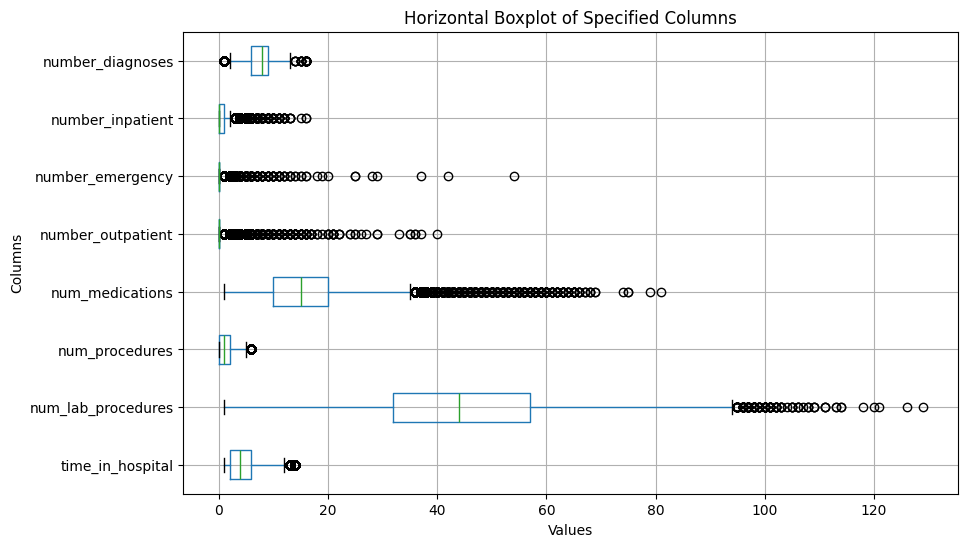

In [22]:
def delete_outliers(df: pd.DataFrame, columns: list[str], threshold: float) -> pd.DataFrame:
    clf = IsolationForest(contamination=threshold)
    outliers = clf.fit_predict(df[columns])
    return df.loc[outliers == 1]

def plot_horizontal_boxplot(df, columns):
    plt.figure(figsize=(10, 6))
    df[columns].boxplot(vert=0)
    plt.title('Horizontal Boxplot of Specified Columns')
    plt.xlabel('Values')
    plt.ylabel('Columns')
    plt.show()

plot_horizontal_boxplot(df, ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'])

In [23]:
df = delete_outliers(df, df.select_dtypes(include=["int64", "float64"]).columns.tolist(), 0.1)

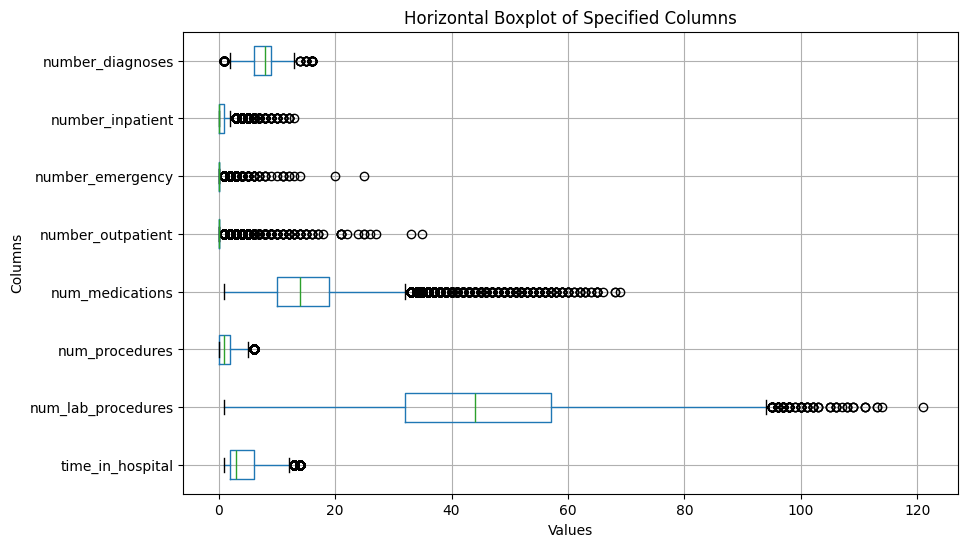

In [24]:
plot_horizontal_boxplot(df, ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'])

In [25]:
df.columns.size

44

In [26]:
X = df

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=3) # n_components=10
X_pca = pca.fit_transform(X)

In [27]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
# print("Principal components:", pca.components_)
# print("Mean vector:", pca.mean_)
print("Singular values:", pca.singular_values_)
print("Number of components:", pca.n_components_)
# print("Number of features:", pca.n_features_)
print("Number of samples:", pca.n_samples_)

Explained variance ratio: [0.25203499 0.08333844 0.07259847]
Singular values: [147.48752475  84.81009498  79.15686783]
Number of components: 3
Number of samples: 64366


In [28]:
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
n_components_to_explain_80_percent = (explained_variance_ratio_cumsum <= 0.8).sum() + 1

pca = PCA(n_components=n_components_to_explain_80_percent)
X_pca = pca.fit_transform(X)


print(pca.components_.shape)
print(X_pca.shape[1])

(4, 44)
4


In [29]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: 0.4675137373669668


In [30]:
kmean_params = {
    "n_clusters": [2, 3, 4, 5],
    # "n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "init": ["k-means++"],
}

kmean_grid = ParameterGrid(kmean_params)

In [31]:
kmeans_silhouette_scores = []

for params in tqdm.tqdm(kmean_grid):
    # with config_context(target_offload="gpu:0"):
    kmeans = KMeans(**params)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_pca, labels)
    kmeans_silhouette_scores.append(score)
    
kmeans_best_params = list(kmean_grid)[np.argmax(kmeans_silhouette_scores)]

100%|██████████| 9/9 [08:13<00:00, 54.89s/it]


In [32]:
print("KMeans Results:")
print(f"Best Parameters: {kmeans_best_params}")
print(f"Best Silhouette Score: {np.max(kmeans_silhouette_scores)}")

KMeans Results:
Best Parameters: {'init': 'k-means++', 'n_clusters': 3}
Best Silhouette Score: 0.5508187361449615


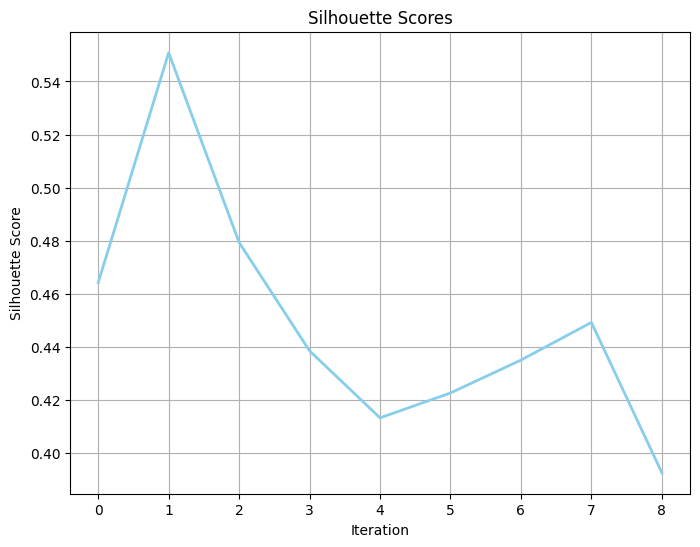

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(kmeans_silhouette_scores, color="skyblue", lw=2)
plt.title("Silhouette Scores")
plt.xlabel("Iteration")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [34]:
# Clustering
best_kmeans = KMeans(**kmeans_best_params)
best_kmeans.fit(X_pca)

KMeans(n_clusters=3)

In [35]:
with open("../models/best_kmeans.pkl", "wb") as f:
    pickle.dump(best_kmeans, f)

In [36]:
db_params = {
    # "eps": [0.4, 0.5],
    "eps": [0.1, 0.2, 0.3, 0.4, 0.5],
    "min_samples": [3, 5, 10],
    # "min_samples": [5, 10, 20, 25],
}

db_grid = ParameterGrid(db_params)

In [37]:
dbscan_silhouette_scores = []

for params in tqdm.tqdm(db_grid):
    db = DBSCAN(**params)
    db.fit(X_pca)
    labels = db.labels_
    
    try:
        score = silhouette_score(X_pca, labels)
    except ValueError:
        # Handle the case where there is only one cluster or no clusters
        score = float('-inf')  # or some other placeholder
    
    dbscan_silhouette_scores.append(score)

dbscan_best_params = list(db_grid)[np.argmax(dbscan_silhouette_scores)]

100%|██████████| 20/20 [21:09<00:00, 63.47s/it]


In [38]:
print("DBSCAN Results:")
print(f"Best Parameters: {dbscan_best_params}")
print(f"Best Silhouette Score: {np.max(dbscan_silhouette_scores)}")

DBSCAN Results:
Best Parameters: {'eps': 0.3, 'min_samples': 5}
Best Silhouette Score: 0.5508187361449615


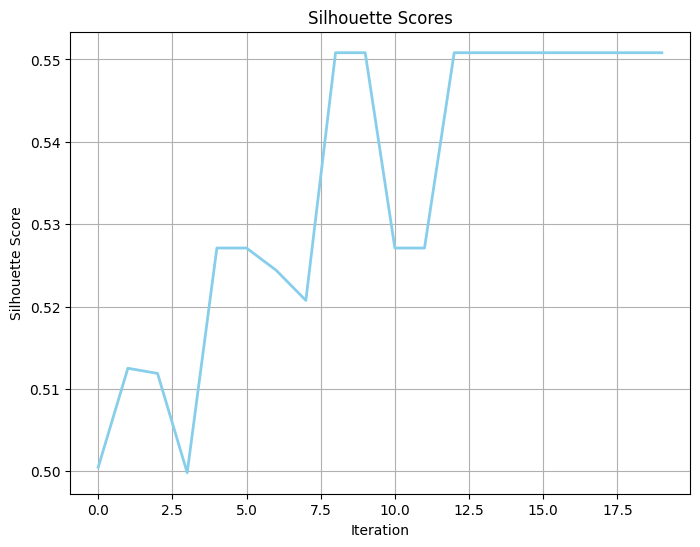

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(dbscan_silhouette_scores, color="skyblue", lw=2)
plt.title("Silhouette Scores")
plt.xlabel("Iteration")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [40]:
best_db = DBSCAN(**dbscan_best_params)
best_db.fit(X_pca)

DBSCAN(eps=0.3)

In [41]:
with open("../models/best_db.pkl", "wb") as f:
    pickle.dump(best_db, f)

In [42]:
with open("../models/best_kmeans.pkl", "rb") as f:
    best_kmeans = pickle.load(f)
    
with open("../models/best_db.pkl", "rb") as f:
    best_db = pickle.load(f)

In [43]:
with open("../result/result.csv", "w") as f:
    kmeans_labels = best_kmeans.labels_
    db_labels = best_db.labels_
    f.write("id_encounter,kmeans_label,dbscan_label\n")
    ids = df["encounter_id"].values
    for i in range(len(ids)):
        f.write(f"{ids[i]},{kmeans_labels[i]},{db_labels[i]}\n")

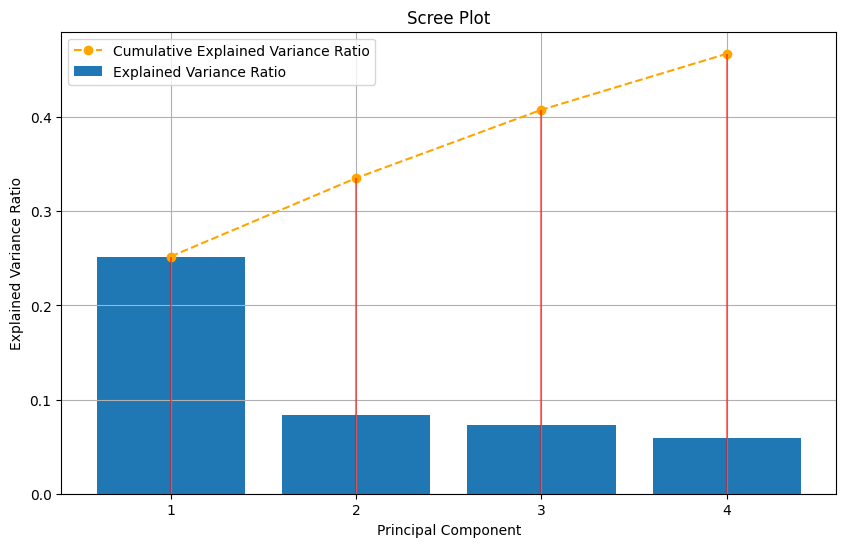

In [44]:
def plot_scree_plot(explained_variance_ratio):
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color='orange', label='Cumulative Explained Variance Ratio')
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Explained Variance Ratio')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
    plt.grid(True)
    plt.legend()

    for i in range(len(explained_variance_ratio)):
        plt.vlines(x=i + 1, ymin=0, ymax=cumulative_variance_ratio[i], colors='red', alpha=0.5)

    plt.show()

plot_scree_plot(pca.explained_variance_ratio_)


3


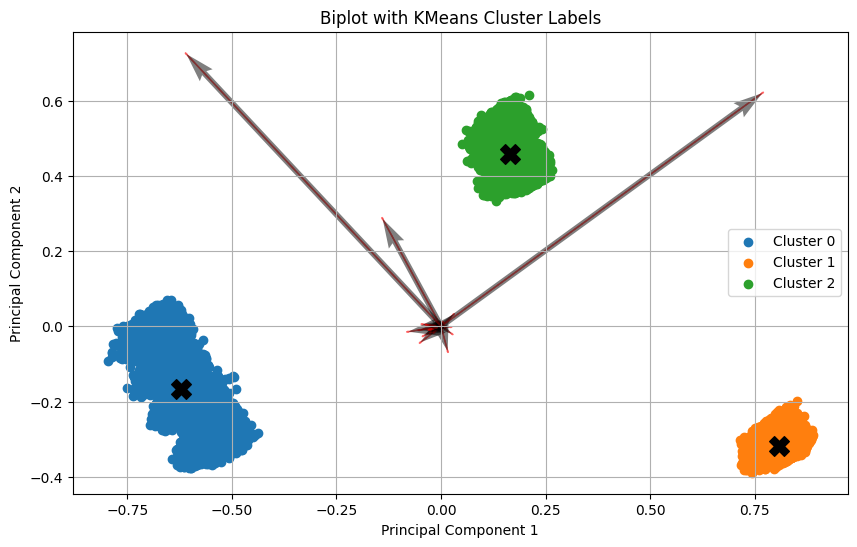

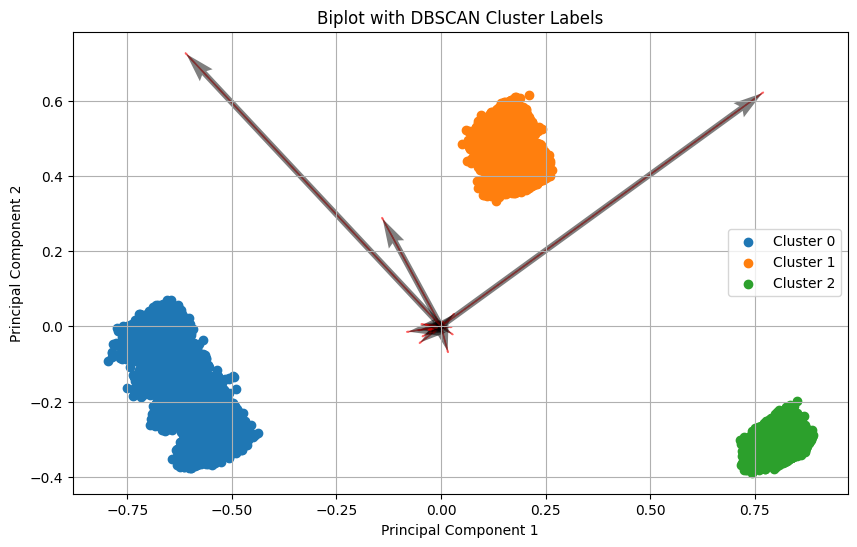

In [45]:
def plot_biplot_with_clusters(X_pca, labels, pca_components, clustering_method, n_clusters=None, cluster_centers=None):
    plt.figure(figsize=(10, 6))

    if clustering_method == "KMeans":
        for cluster_label in range(n_clusters):
            # Scatter plot of data points
            plt.scatter(X_pca[labels == cluster_label, 0], X_pca[labels == cluster_label, 1], label=f'Cluster {cluster_label}')
            # Calculate and plot cluster centers
            cluster_center = cluster_centers[cluster_label]
            plt.scatter(cluster_center[0], cluster_center[1], s=200, c='black', marker='X')
    
    elif clustering_method == "DBSCAN":
        unique_labels = np.unique(labels)
        for cluster_label in unique_labels:
            if cluster_label == -1:
                # Points labeled as noise
                noise_mask = labels == cluster_label
                plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], c='black', alpha=0.5, label='Noise')
            else:
                # Points in clusters
                cluster_mask = labels == cluster_label
                plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], label=f'Cluster {cluster_label}')
    
    # Biplot arrows
    for i, (component1, component2) in enumerate(zip(pca_components[0], pca_components[1])):
        plt.arrow(0, 0, component1, component2, color='r', alpha=0.5)
        plt.quiver(0, 0, component1, component2, angles='xy', scale_units='xy', scale=1, alpha=0.5)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Biplot with {clustering_method} Cluster Labels')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example for KMeans
print(kmeans_best_params['n_clusters'])
plot_biplot_with_clusters(X_pca, best_kmeans.labels_, pca.components_, "KMeans", n_clusters=kmeans_best_params['n_clusters'], cluster_centers=best_kmeans.cluster_centers_)

# Usage example for DBSCAN
plot_biplot_with_clusters(X_pca, best_db.labels_, pca.components_, "DBSCAN")


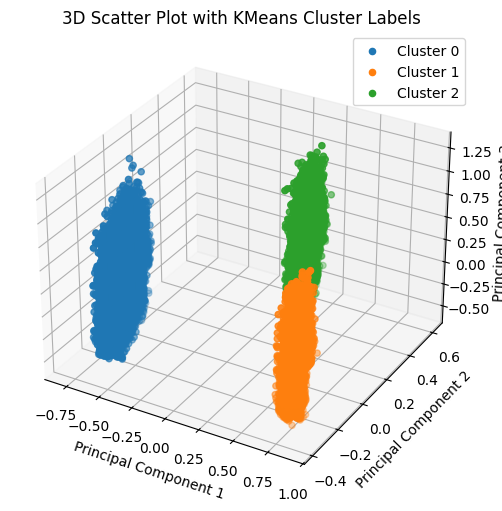

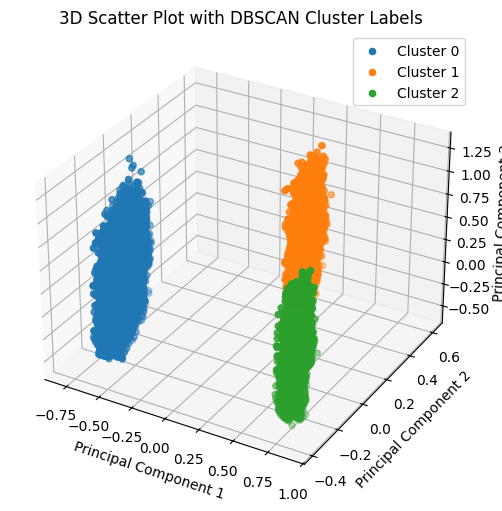

In [47]:
def plot_3d_scatter_with_clusters(X_pca, labels, clustering_method, n_clusters=None):
    # Plotting
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    if clustering_method == "KMeans":
        for cluster_label in range(n_clusters):
            ax.scatter(X_pca[labels == cluster_label, 0], X_pca[labels == cluster_label, 1], X_pca[labels == cluster_label, 2], label=f'Cluster {cluster_label}')
    
    elif clustering_method == "DBSCAN":
        unique_labels = np.unique(labels)
        for cluster_label in unique_labels:
            if cluster_label == -1:
                # Points labeled as noise
                noise_mask = labels == cluster_label
                ax.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], X_pca[noise_mask, 2], c='black', alpha=0.5, label='Noise')
            else:
                # Points in clusters
                cluster_mask = labels == cluster_label
                ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], X_pca[cluster_mask, 2], label=f'Cluster {cluster_label}')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(f'3D Scatter Plot with {clustering_method} Cluster Labels')

    ax.legend()
    plt.show()

# Usage example for KMeans
plot_3d_scatter_with_clusters(X_pca, best_kmeans.labels_, "KMeans", n_clusters=kmeans_best_params['n_clusters'])

# Usage example for DBSCAN
plot_3d_scatter_with_clusters(X_pca, best_db.labels_, "DBSCAN")
